In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/avocado-prices/avocado.csv


In [2]:
import pandas as pd
data = pd.read_csv("../input/avocado-prices/avocado.csv")
data

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [3]:
cols = ['Date', 'AveragePrice', 'type', 'region']
df = data[cols]
df = df[(df.region =='TotalUS') & (df.type == 'conventional') ] #& (df.Date >= '2016-01-01')

del df['region']
del df['type']

df = df.sort_values("Date")

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()
d_df.columns = ['ds', 'y']

# Train test split 
n_weeks = 30
train = d_df[:-n_weeks]
test = d_df[-n_weeks:]

In [4]:
train.head(10)

,ds,y
0,2015-01-04,0.95
7,2015-01-11,1.01
14,2015-01-18,1.03
21,2015-01-25,1.04
28,2015-02-01,0.89
35,2015-02-08,0.95
42,2015-02-15,1.03
49,2015-02-22,1.02
56,2015-03-01,0.97
63,2015-03-08,1.02


In [6]:
class model:
    def __init__(
        self,
        T,
        K,
        t,
        y,
        S,
        t_change,
        X,
        sigmas,
        tau,
        s_a,
        
    ):
        self.T = T
        self.K = K
        self.t = t
        self.y = y
        self.S = S
        self.t_change = t_change
        self.X = X
        self.sigmas = sigmas
        self.tau = tau
        self.s_a = s_a
        
        self.cap = None
        self.s_m = None
        self.A = None
        
    def get_changepoint_matrix(self, t,  t_change, T, S):
        A = np.zeros((T,S))
        a_row = np.zeros(S)
        cp_idx = 1
        t = t.tolist()
        for i in range(T):
            while ((cp_idx < S) and t[i] >= t_change[cp_idx]):
                a_row[cp_idx] = 1
                cp_idx = cp_idx + 1
            A[i] = a_row
        self.A = A
        return A
    
    def linear_trend(
        k,
        m,
        delta,
        t,
        A,
        t_change
    ):
        return np.dot((k + A * delta) , t) + (m + A * np.dot(-t_change , delta))

In [29]:
from collections import OrderedDict, defaultdict
class prophet:
    def __init__(
        self,
        growth='linear',
        changepoints=None,
        n_changepoints=25,
        changepoint_range=0.8,
        seasonality_mode='additive',
        seasonality_prior_scale=10.0,
        changepoint_prior_scale=0.05,
    ):
        self.growth = growth
        self.start = None
        self.y_scale = None
        self.t_scale = None
        self.changepoints_t = None
        self.seasonalities = OrderedDict({})
        from fbprophet import Prophet
        self.extra_regressors = OrderedDict({})
        self.country_holidays = None
        
        
        m = Prophet(growth = 'linear')
        m.fit(train)
        future = m.make_future_dataframe(periods=n_weeks, freq='W')
        forecast = m.predict(future)
        self.forecast = forecast
        self.stan_fit = None
        self.params = {}
        
        self.changepoints = pd.to_datetime(changepoints)
        self.n_changepoints = n_changepoints
        self.specified_changepoints = False
        self.changepoint_range = changepoint_range
        self.changepoint_prior_scale = float(changepoint_prior_scale)
        
        self.seasonality_mode = 'additive'
        self.seasonality_prior_scale = float(seasonality_prior_scale)
#         self.yearly_seasonality = auto
        
        self.history = None
        self.history_dates = None
        self.train_component_cols = None
        self.component_modes = None
        self.train_holiday_names = None
        
        self.test_output = None
        pass
    
    def setup_dataframe(self, df):
        self.y_scale = (df['y'] - 0).abs().max()
        self.start = df['ds'].min()
        self.t_scale = df['ds'].max() - self.start
        df['floor'] = 0
        df['t'] = (df['ds'] - self.start) / self.t_scale
        df['y_scaled'] = (df['y'] - df['floor']) / self.y_scale
        return df
    
    def fit(self,df):
        history = df[df['y'].notnull()].copy()
        history = self.setup_dataframe(history)
        self.history = history
        self.seasonalities['yearly'] = {
            'period': 365.25,
            'fourier_order': 10,
            'prior_scale': self.seasonality_prior_scale,
            'mode': self.seasonality_mode,
        }
        seasonal_features, prior_scales, component_cols, modes = (
            self.make_all_seasonality_features(history))
        self.train_component_cols = component_cols
        self.component_modes = modes
        self.set_changepoint()
        
        dat = {
            'T': history.shape[0],
            'K': seasonal_features.shape[1],
            'S': len(self.changepoints_t),
            'y': history['y_scaled'],
            't': history['t'],
            't_change': self.changepoints_t,
            'X': seasonal_features,
            'sigmas': prior_scales,
            'tau': self.changepoint_prior_scale,
            's_a': component_cols['additive_terms'],
            's_m': None,
        }
        
        dat['cap'] = np.zeros(self.history.shape[0])
        kinit = self.linear_growth_init(history)
        
        m = model(
            T = history.shape[0],
            K = seasonal_features.shape[1],
            S = len(self.changepoints_t),
            y = history['y_scaled'],
            t = history['t'],
            t_change = self.changepoints_t,
            X = seasonal_features,
            sigmas = prior_scales,
            tau = self.changepoint_prior_scale,
            s_a = component_cols['additive_terms'],
        )
        
        self.test_output = m.get_changepoint_matrix(history['t'],self.changepoints_t,history.shape[0],len(self.changepoints_t))
        return self 
    
    def make_all_seasonality_features(self, df):
        seasonal_features = []
        prior_scales = []
        modes = {'additive': []}

        # Seasonality features
        for name, props in self.seasonalities.items():
            features = self.make_seasonality_features(
                df['ds'],
                props['period'],
                props['fourier_order'],
                name,
            )
            seasonal_features.append(features)
            prior_scales.extend(
                [props['prior_scale']] * features.shape[1])
            modes[props['mode']].append(name)
            
        seasonal_features = pd.concat(seasonal_features, axis=1)
        component_cols, modes = self.regressor_column_matrix(
            seasonal_features, modes
        )
        return seasonal_features, prior_scales, component_cols, modes
    
    @classmethod
    def fourier_series(self, dates, period, series_order):
        t = np.array((dates - pd.datetime(1970, 1, 1)).dt.total_seconds().astype(np.float)) / (3600 * 24.)
        return np.column_stack([
            fun((2.0 * (i + 1) * np.pi * t / period))
            for i in range(series_order)
            for fun in (np.sin, np.cos)
        ])
    
    def make_seasonality_features(cls, dates, period, series_order, prefix):
        features = cls.fourier_series(dates,period,series_order)
        columns = [
            '{}_delim_{}'.format(prefix, i + 1)
            for i in range(features.shape[1])
        ]
        return pd.DataFrame(features, columns=columns)
    
    def regressor_column_matrix(self, seasonal_features, modes):
        components = pd.DataFrame({
            'col': np.arange(seasonal_features.shape[1]),
            'component': [
                x.split('_delim_')[0] for x in seasonal_features.columns
            ],
        })
        # Add total for holidays
        if self.train_holiday_names is not None:
            components = self.add_group_component(
                components, 'holidays', self.train_holiday_names.unique())
        # Add totals additive and multiplicative components, and regressors
        for mode in ['additive']:
            components = self.add_group_component(
                components, mode + '_terms', modes[mode]
            )
            regressors_by_mode = [
                r for r, props in self.extra_regressors.items()
                if props['mode'] == mode
            ]
            components = self.add_group_component(
                components, 'extra_regressors_' + mode, regressors_by_mode)
            # Add combination components to modes
            modes[mode].append(mode + '_terms')
            modes[mode].append('extra_regressors_' + mode)
        # After all of the additive/multiplicative groups have been added,
        modes[self.seasonality_mode].append('holidays')
        # Convert to a binary matrix
        component_cols = pd.crosstab(
            components['col'], components['component'],
        ).sort_index(level='col')
        # Add columns for additive and multiplicative terms, if missing
        for name in ['additive_terms']:
            if name not in component_cols:
                component_cols[name] = 0
        # Remove the placeholder
        component_cols.drop('zeros', axis=1, inplace=True, errors='ignore')
        # Compare to the training, if set.
        if self.train_component_cols is not None:
            component_cols = component_cols[self.train_component_cols.columns]
        return component_cols, modes
    
    def add_group_component(self, components, name, group):
        new_comp = components[components['component'].isin(set(group))].copy()
        group_cols = new_comp['col'].unique()
        if len(group_cols) > 0:
            new_comp = pd.DataFrame({'col': group_cols, 'component': name})
            components = components.append(new_comp)
        return components
    
    def set_changepoint(self):
        hist_size = int(np.floor(self.history.shape[0] * self.changepoint_range))
        cp_indexes = (np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(np.int))
        self.changepoints = (self.history.iloc[cp_indexes]['ds'].tail(-1))
        self.changepoints_t = np.sort(np.array((self.changepoints - self.start) / self.t_scale))
        pass
    
    def linear_growth_init(self,df):
        i0 = 0
        i1 = 138
        T = df['t'].iloc[i1] - df['t'].iloc[i0]
        k = (df['y_scaled'].iloc[i1] - df['y_scaled'].iloc[i0]) / T
        m = df['y_scaled'].iloc[i0] - k * df['t'].iloc[i0]
        return (k, m)
    

In [30]:
m1 = prophet()
m1.fit(train)

In [32]:
forecast = m1.forecast
test = pd.concat([test.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')
cols = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test = test[cols]
test['y'] = test.y
test['yhat'] = (test.yhat).round(2)
test['yhat_lower'] = (test.yhat_lower).round(2)
test['yhat_upper'] = (test.yhat_upper).round(2)

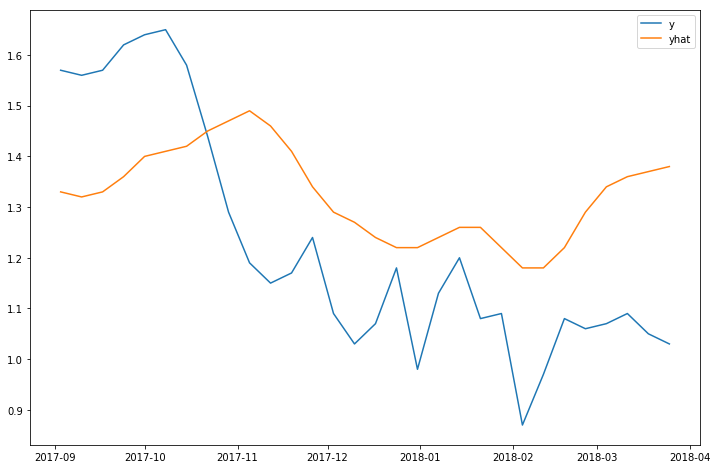

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.plot(test.y)
plt.plot(test.yhat)
plt.legend();

In [35]:
test['e'] = test.y - test.yhat

rmse = np.sqrt(np.mean(test.e**2)).round(2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 0)
print('RMSE = $', rmse)
print('MAPE =', mape, '%')

RMSE = $ 0.22
MAPE = 18.0 %
